# Lab 2: Cats vs Dogs

**Deadline**: September 29, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Kevin Course

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

### Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file.

## Colab Link

Include a link to your colab file here

Colab Link: 

In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [0]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Returns the indices for datapoints in the dataset that
    belongs to the desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    # define classes
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    
    # chain transforms together with Compose.
    # 1. Convert to tensor
    # 2. Normalize with <meanR, meanG, meanB>, <stdR, stdG, stdG>, std=standard deviation
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    # dataset[x][1] contains information about class, number represents class from classes tuple.
    relevant_train_indices = get_relevant_indices(
            trainset,
            classes,
            target_classes)
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_train_indices)
    split = int(len(relevant_train_indices) * 0.8)
    relevant_train_indices, relevant_val_indices = relevant_train_indices[:split], relevant_train_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices) # random sampling - training dataset
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler) # dataloader training; num workers > 0 -> multithreading
    val_sampler = SubsetRandomSampler(relevant_val_indices) # random sampling - evaluation dataset
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler) # dataloader eval; num workers > 0 -> multithreading
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [0]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Files already downloaded and verified
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

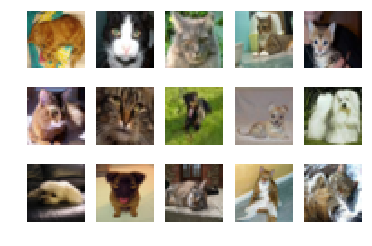

In [0]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

We have int(10000 \* 2 \* 0.8)=16000 training examples, int(10000 \* 2 \* 0.2)=4000 validation examples, and 2000 test examples

### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

We will overfit our model if we rely only on the training set loss/error. The validation error allows us to predict the real world performance of the model and judge based on its errors and losses whether the model is in danger of overfitting.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [0]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [0]:
print("small")
for param in small_net.parameters():
    print(param.shape)

# total number of parameters of small net = 5*3*3*3+5+1*245+1 = 386
print("large")
for param in large_net.parameters():
    print(param.shape)

# total number of parameters of large net = 5*3*5*5+5+10*5*5*5+10+32*250+32+1*32+1 = 9705

small
torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
386
large
torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

<img src="Diagram.png" width=60%>

In [0]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [0]:
batch_size=64, learning_rate=0.01, num_epochs=30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

model_small_net_bs64_lr0.01_epoch5_train_err.csv - evolution of error with training data

model_small_net_bs64_lr0.01_epoch5_train_loss.csv - evolution of loss with training data

model_small_net_bs64_lr0.01_epoch5_val_err.csv - evolution of error using validation data

model_small_net_bs64_lr0.01_epoch5_val_loss.csv - evolution of loss using validation data

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [0]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

#from google.colab import drive
#drive.mount('/content/gdrive')

In [0]:
train_net(small_net)

"""
Total time elapsed: 257.15 seconds

"""

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.429, Train loss: 0.6737350678443909 |Validation err: 0.369, Validation loss: 0.6512005943804979
Epoch 2: Train err: 0.353125, Train loss: 0.6380053734779358 |Validation err: 0.363, Validation loss: 0.6512419860810041
Epoch 3: Train err: 0.338875, Train loss: 0.6219190330505371 |Validation err: 0.3385, Validation loss: 0.6186652015894651
Epoch 4: Train err: 0.328, Train loss: 0.6075829720497131 |Validation err: 0.351, Validation loss: 0.6225572526454926
Epoch 5: Train err: 0.321, Train loss: 0.5987969076633454 |Validation err: 0.335, Validation loss: 0.6110742799937725
Epoch 6: Train err: 0.3065, Train loss: 0.5870932002067566 |Validation err: 0.332, Validation loss: 0.6092408057302237
Epoch 7: Train err: 0.306875, Train loss: 0.5811517515182495 |Validation err: 0.3305, Validation loss: 0.6026261122897267
Epoch 8: Train err: 0.29675, Train loss: 0.5719554803371429 |Validation err: 0.3185, V

In [0]:
train_net(large_net)

"""
Total time elapsed: 310.57 seconds

"""

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.449125, Train loss: 0.6894809503555298 |Validation err: 0.4285, Validation loss: 0.6793084144592285
Epoch 2: Train err: 0.414625, Train loss: 0.6749964542388917 |Validation err: 0.4165, Validation loss: 0.6779212411493063
Epoch 3: Train err: 0.386375, Train loss: 0.6581112213134765 |Validation err: 0.3655, Validation loss: 0.6400552056729794
Epoch 4: Train err: 0.3545, Train loss: 0.6348590712547302 |Validation err: 0.3815, Validation loss: 0.6489515416324139
Epoch 5: Train err: 0.340375, Train loss: 0.6179988675117493 |Validation err: 0.336, Validation loss: 0.6160655524581671
Epoch 6: Train err: 0.327, Train loss: 0.5980421864986419 |Validation err: 0.332, Validation loss: 0.6225195825099945
Epoch 7: Train err: 0.316375, Train loss: 0.5899531269073486 |Validation err: 0.3235, Validation loss: 0.592940024100244
Epoch 8: Train err: 0.300375, Train loss: 0.5696551434993744 |Validation err: 

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

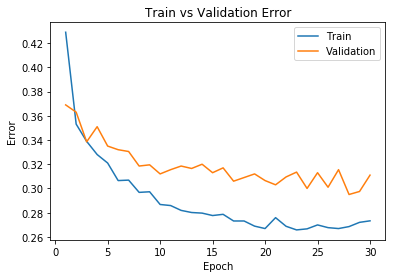

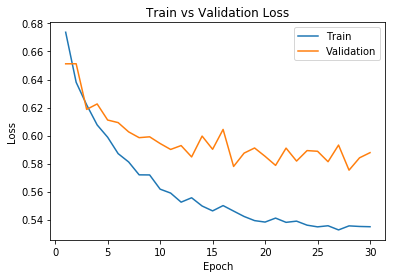

In [0]:
model_path_small = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_small)

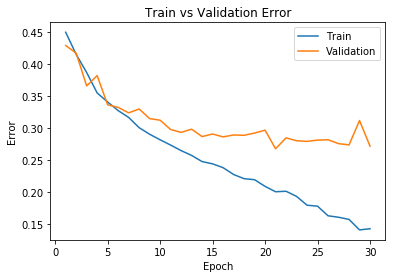

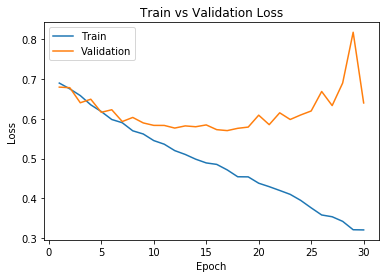

In [0]:
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

Small net has a training error which is decreasing exponentially with the number of epochs while large net has a training error which is decreasing linearly. The same observation is true for training loss. While the training error is less for large_net, the validation error, or real world performance, of both large_net and small_net are rougly the same at the end, at around 0.30.

In addition, the training loss is also less for large_net at the end of the training process, however, there is a trend of overfitting occuring in the large_net - the validation loss began to increase at around epoch 15 and the validation error remained stable while the training error kept decreasing.

There do not seem to be any instances of underfitting as the validation errors for both nets seem to asymptotically stabilize at 0.3, while the smallest validation loss is around 0.6 in both large_net and small_net. Thus there is an lower limit to the errors and losses in both cases, which higlights the performance limitations of CNNs.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [0]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)
"""
Total time elapsed: 316.41 seconds
"""

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360090255737 |Validation err: 0.467, Validation loss: 0.6924686636775732
Epoch 2: Train err: 0.44875, Train loss: 0.6922589564323425 |Validation err: 0.4305, Validation loss: 0.6916492227464914
Epoch 3: Train err: 0.435625, Train loss: 0.6916066970825195 |Validation err: 0.4285, Validation loss: 0.6908543817698956
Epoch 4: Train err: 0.43, Train loss: 0.6908613438606263 |Validation err: 0.425, Validation loss: 0.689659558236599
Epoch 5: Train err: 0.434375, Train loss: 0.6899194374084473 |Validation err: 0.4195, Validation loss: 0.6886940244585276
Epoch 6: Train err: 0.435875, Train loss: 0.6887415566444397 |Validation err: 0.4195, Validation loss: 0.6867833752185106
Epoch 7: Train err: 0.437, Train loss: 0.6873774523735047 |Validation err: 0.4185, Validation loss: 0.6851979978382587
Epoch 8: Train err: 0.437375, Train loss: 0.6859259343147278 |Validation err: 0.41

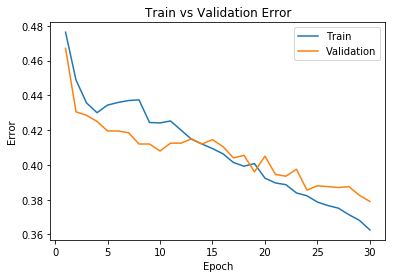

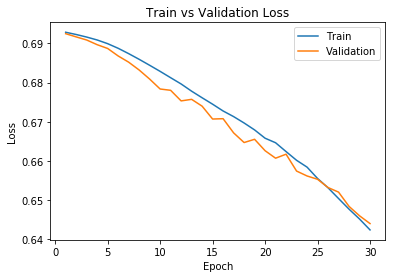

In [0]:
model_path_large2 = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_large2)

The model took 6 seconds more time to train. While the error for both training and validation increased, there is no longer the problem of overfitting, as the error for the training data follows closely with the error for validation data. Likewise a similar trend is apparent for the training and validation loss plot.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [0]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.1)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.427625, Train loss: 0.6739832162857056 |Validation err: 0.3755, Validation loss: 0.6454853042960167
Epoch 2: Train err: 0.3675, Train loss: 0.6370385904312134 |Validation err: 0.36, Validation loss: 0.6294329389929771
Epoch 3: Train err: 0.361625, Train loss: 0.630808758020401 |Validation err: 0.3265, Validation loss: 0.6084360517561436
Epoch 4: Train err: 0.331875, Train loss: 0.6086332263946533 |Validation err: 0.325, Validation loss: 0.59028812777251
Epoch 5: Train err: 0.32775, Train loss: 0.6011228070259095 |Validation err: 0.324, Validation loss: 0.5849181935191154
Epoch 6: Train err: 0.306375, Train loss: 0.5759226620197296 |Validation err: 0.315, Validation loss: 0.5952497506514192
Epoch 7: Train err: 0.300625, Train loss: 0.5679020948410034 |Validation err: 0.3295, Validation loss: 0.5981702776625752
Epoch 8: Train err: 0.281125, Train loss: 0.5518934576511383 |Validation err: 0.3

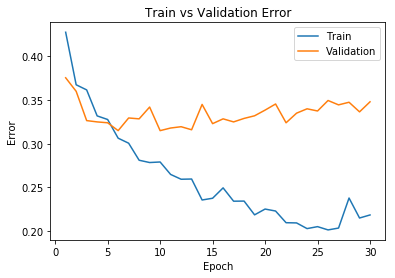

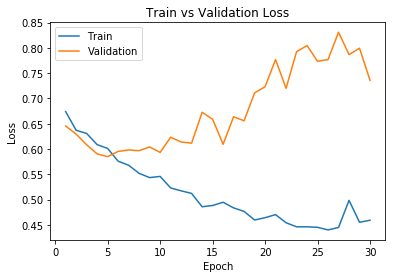

In [0]:
model_path_large3 = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path_large3)

The model took more time to train, around 12 seconds more. Increasing the learning rate has a detrimental effect on the performance of the neural network, as it caused significant deviations between training and validation error and loss. In addition, the validation loss and training error actually increased after an early point in the graph, beginning at around epoch 5. This means that there is significant overfitting occuring in the neural net.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [0]:
large_net = LargeNet()
train_net(large_net, batch_size=512)

"""
Total time elapsed: 305.01 seconds
"""

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379403591156 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500516235828 |Validation err: 0.4265, Validation loss: 0.690913051366806
Epoch 4: Train err: 0.433625, Train loss: 0.6908450201153755 |Validation err: 0.424, Validation loss: 0.6897871196269989
Epoch 5: Train err: 0.434, Train loss: 0.6896936073899269 |Validation err: 0.424, Validation loss: 0.6881358921527863
Epoch 6: Train err: 0.43825, Train loss: 0.6883534975349903 |Validation err: 0.4285, Validation loss: 0.6860131174325943
Epoch 7: Train err: 0.439375, Train loss: 0.6866878308355808 |Validation err: 0.426, Validation loss: 0.6836972236633301
Epoch 8: Train err: 0.43525, Train loss: 0.6849784925580025 |Validation err: 0.4115,

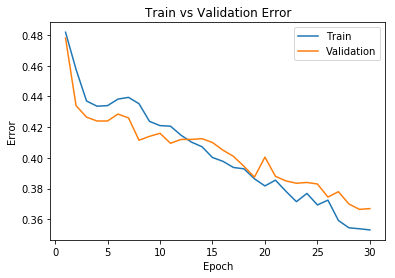

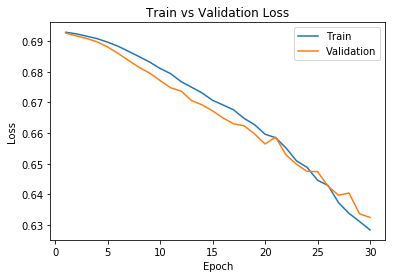

In [0]:
model_path_large4 = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large4)

The model took 5 seconds less to train. The training error and validation error increased when compared with default parameters, while the training loss and validation loss remained roughly equal. There is no longer the problem of overfitting, as the error and loss for the training data follows closely with the error and loss for validation data. Both error and loss decrease as the number of epochs increased.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [0]:
large_net = LargeNet()
train_net(large_net, batch_size=16)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.432, Train loss: 0.6775538707375527 |Validation err: 0.379, Validation loss: 0.6519261527061463
Epoch 2: Train err: 0.36925, Train loss: 0.6397365355491638 |Validation err: 0.3445, Validation loss: 0.617981910943985
Epoch 3: Train err: 0.339375, Train loss: 0.6102552083134651 |Validation err: 0.3505, Validation loss: 0.6444977684020996
Epoch 4: Train err: 0.3185, Train loss: 0.5869817495942116 |Validation err: 0.3435, Validation loss: 0.611754653453827
Epoch 5: Train err: 0.306125, Train loss: 0.5664897943139077 |Validation err: 0.306, Validation loss: 0.5825917682647705
Epoch 6: Train err: 0.283625, Train loss: 0.5470024206936359 |Validation err: 0.3055, Validation loss: 0.589823650598526
Epoch 7: Train err: 0.271, Train loss: 0.532670950949192 |Validation err: 0.3125, Validation loss: 0.5940433223247528
Epoch 8: Train err: 0.26075, Train loss: 0.5134506115317344 |Validation err: 0.33, Va

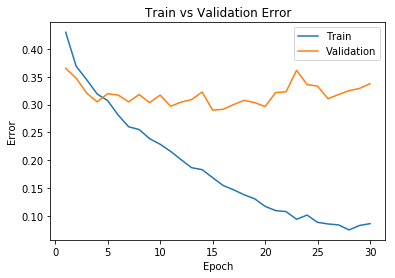

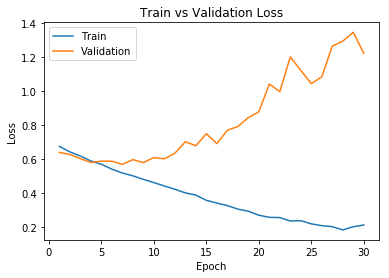

In [0]:
model_path_large5 = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large5)

The model takes 46 seconds longer to train. Decreasing the batch size increased the validation loss significantly at higher epoch numbers when compared with the default values. The validation error is roughly equal to the error with default values, at around 0.30. The training error decreased, however, indicating problems with overfitting.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [0]:
Based on the results above it is apparent that increasing the batch size and decreasing the learning rate negatively affected the validation accuracy, although the parameters did prevent overfitting. In addition, the negative effects are not as significant as those present when decreasing the batch size and increasing the learning rate. The size of the neural network also did not affect the validation accuracy too much, it did seem to improve it by a few percentage points. Since increasing the batch size and decreasing the learning rate did have the positive benefit of preventing overfitting, I will investigate the effect of increasing the batch size but to a size smaller than in question 3(c). I will also decrease the learning rate to a value that is greater than 3(a). Therefore I will choose the following set of values:

network: large
batch_size: 256 (default: 64)
learning rate: 0.005 (default: 0.01)


### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [0]:
large_net = LargeNet()
train_net(large_net, batch_size=256, learning_rate=0.005, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.477625, Train loss: 0.6928693521767855 |Validation err: 0.4685, Validation loss: 0.6925142630934715
Epoch 2: Train err: 0.451125, Train loss: 0.692245177924633 |Validation err: 0.436, Validation loss: 0.6914754882454872
Epoch 3: Train err: 0.435375, Train loss: 0.6914684139192104 |Validation err: 0.4265, Validation loss: 0.6905744448304176
Epoch 4: Train err: 0.428625, Train loss: 0.6903847754001617 |Validation err: 0.419, Validation loss: 0.6891285181045532
Epoch 5: Train err: 0.43725, Train loss: 0.6891181115061045 |Validation err: 0.425, Validation loss: 0.6870634332299232
Epoch 6: Train err: 0.435125, Train loss: 0.6875761225819588 |Validation err: 0.423, Validation loss: 0.6847703978419304
Epoch 7: Train err: 0.435625, Train loss: 0.6857248228043318 |Validation err: 0.417, Validation loss: 0.6822871416807175
Epoch 8: Train err: 0.4315, Train loss: 0.6840815525501966 |Validation err: 0

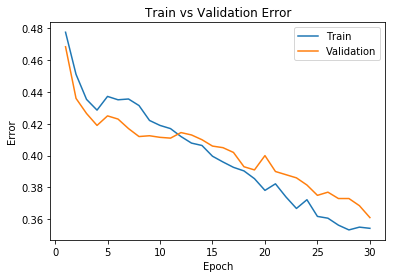

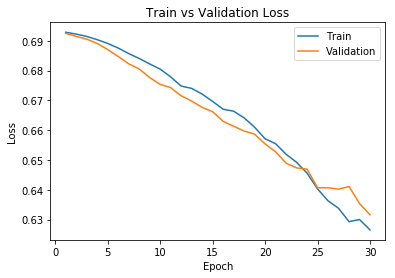

In [0]:
model_path_large6 = get_model_name("large", batch_size=256, learning_rate=0.005, epoch=29)
plot_training_curve(model_path_large6)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [0]:
The error and loss results did not show significant improvement from the original. Rather, the validation error actually increased. However the computational time decreased noticeably (by 20 seconds). I will try a smaller batch size to minimize the validation error and larger learning rate to offset some of the potential overfitting effects of decreasing the batch size.  
network: large  
batch_size: 64 (default: 64, previous: 256)  
learning rate: 0.008 (default: 0.01, previous: 0.007)  

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [0]:
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.008, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.444375, Train loss: 0.6908339948654175 |Validation err: 0.4355, Validation loss: 0.6842103004455566
Epoch 2: Train err: 0.428375, Train loss: 0.6817337331771851 |Validation err: 0.4135, Validation loss: 0.6747962664812803
Epoch 3: Train err: 0.40625, Train loss: 0.6710912775993347 |Validation err: 0.4025, Validation loss: 0.6593667697161436
Epoch 4: Train err: 0.3875, Train loss: 0.6587790093421936 |Validation err: 0.3895, Validation loss: 0.6506150979548693
Epoch 5: Train err: 0.3715, Train loss: 0.6464620947837829 |Validation err: 0.366, Validation loss: 0.6407646480947733
Epoch 6: Train err: 0.3485, Train loss: 0.6297836966514587 |Validation err: 0.3495, Validation loss: 0.6284362878650427
Epoch 7: Train err: 0.34125, Train loss: 0.6171645402908326 |Validation err: 0.3435, Validation loss: 0.6182761266827583
Epoch 8: Train err: 0.3265, Train loss: 0.6007437398433685 |Validation err: 0.3

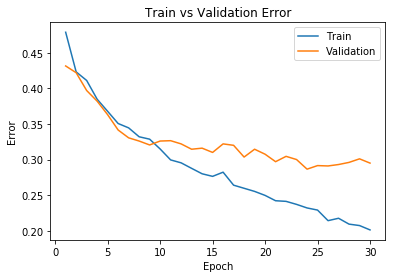

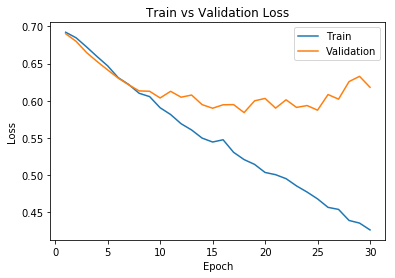

In [0]:
model_path_large9 = get_model_name("large", batch_size=64, learning_rate=0.008, epoch=29)
plot_training_curve(model_path_large9)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [0]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=64, learning_rate=0.008, epoch=10)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

The parameters represent the optimal solution due to the following reasons:  
1) The validation error decreases and shows signs of asymptotic stability; this means that the validation error has reached a minimum.  
2) The validation loss is less than that of the original model with default parameters; this means that there is much less overfitting occuring in my model

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [0]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

criterion = nn.BCEWithLogitsLoss()
err, loss = evaluate(net,test_loader,criterion)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
err

0.3125

The test classification error is 0.3125

### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

It is slightly higher than the validation error (0.3125 vs 0.295). I would expect it to be higher because the test set is only run through the model once, versus the validation set which is run through the model over several epochs.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

We use the test set at the very end to verify that our model indeed does have a performance similar to that seen for the validation dataset. We use the test data as little as possible to ensrue that minimal overfitting occurs with the test data and that we get an accuraterepresentation of the ability of the model to act on real-life data sets.

### Part (f) - 5pt

Train a 2-layer ANN similar to what was used in Lab 1 to classific cats and dogs. Try out different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data. How does the ANN model compare to your CNN model?

In [0]:
torch.manual_seed(1) # set the random seed

# define a 2-layer ann
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.name = "ann"
        self.layer1 = nn.Linear(3*32*32, 1024)
        self.layer2 = nn.Linear(1024, 1)

    def forward(self, img):
        flattened = img.view(-1, 3*32*32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2

    
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

ann = ANN()
    
train_net(ann, batch_size=64)



Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.396, Train loss: 0.6611208715438843 |Validation err: 0.382, Validation loss: 0.645833395421505
Epoch 2: Train err: 0.353875, Train loss: 0.6282488579750061 |Validation err: 0.3895, Validation loss: 0.6590909287333488
Epoch 3: Train err: 0.331625, Train loss: 0.6070352997779846 |Validation err: 0.3705, Validation loss: 0.6422362923622131
Epoch 4: Train err: 0.321625, Train loss: 0.5914453718662261 |Validation err: 0.3805, Validation loss: 0.6502843275666237
Epoch 5: Train err: 0.296375, Train loss: 0.5696470160484314 |Validation err: 0.3745, Validation loss: 0.6490732673555613
Epoch 6: Train err: 0.26625, Train loss: 0.5333969027996063 |Validation err: 0.4025, Validation loss: 0.7451636269688606
Epoch 7: Train err: 0.253375, Train loss: 0.5203193538188934 |Validation err: 0.362, Validation loss: 0.6547651253640652
Epoch 8: Train err: 0.226125, Train loss: 0.47769216418266297 |Validation err

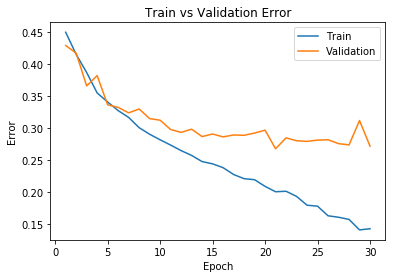

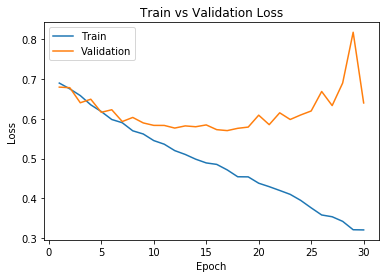

In [0]:
model_path_large10 = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large10)

The validation error and validation loss in the ANN is significantly higher than my model (0.36 vs 0.. This is likely due to overfitting in the ANN model. Neurons in an ANN are fully connected. creating more parameters and increasing the likelihood and speed of overfitting the model. By contrast, in a convolutional neural network, the outputs of each successive layer congregate, reducing the number of parameters and making CNNs less prone to overfitting.